# Guess the movie!
<img src=when-harry-met-sally.jpg>

# Guess the movie!

<img src=royal.png>

# Guess the movie!
<img src=godfather.jpg>

# Films Shot in NYC


<img src=anniehall.jpg>
<img src=dark.jpg>

# Questions
## what are the most popular locations?
## trend of locations over time?
## what movie had the most locations?
## average locations per movie?
## what borough had most locations?

# Outline:
## - Scraped website
## - Questions about the data
## - Exploration
## - Points for future analysis

# Scraped Website
<img src="otsonylogo_2015.jpg">

- website containing over 1,100 movies that were filmed in New York
- photos and addresses of different movie scenes

<img src='otso_1.png'>

<img src='otso_2.png'>

<img src='otso_3.png'>

# Questions about the data
- what movie had the most filmed locations?
- what did the number of filmed locations look like over time?

### Outline
- motivation: favorite movies in NYC
- movies stats, based on film permit data from Mayor's Office of Film: about 17,241 movie scenes filmed between 2011 and 2013
- otsoNY: contains over 1,100 movies that were filmed in NYC
- otsoNY website tour
- questions to answer
- exploration
- where were your favorite movies shot?
- given more time:
    - get a complete list of geocodes for all locations
    - plot all locations on a map
    - arrange by year, genre
    - what were the most popular locations


In [313]:
from pymongo import MongoClient
import pandas as pd
import numpy as np
import sqlite3
import re
import geocoder
from geopy.geocoders import Nominatim
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import chain
import unicodedata
import time
%matplotlib inline

In [242]:
# create Mongo Client to retrieve collections 

client = MongoClient('localhost', 27017)
db = client.nyc_movies_location
movies_df = pd.DataFrame(list(db.location.find()))



In [243]:
movies_df.head()

_id  \
0  5740f84bb104ca565618e27d   
1  5740f84eb104ca565618e27e   
2  5740f850b104ca565618e27f   
3  5740f853b104ca565618e280   
4  5740f857b104ca565618e281   

                                            location  \
0  [Fulton Ferry Pier (Near Brooklyn Bridge) Broo...   
1  [Tavern on the Green (btw West 66th and 67th S...   
2  [The Plaza Hotel, 750 5th Avenue and Central P...   
3  [The Flatiron Building, 175 5th Avenue, Manhat...   
4  [Robert's Apartment, 19 Gramercy Park & East 2...   

                           title  
0          Absolute Trust (2009)  
1  Arthur 2: On the Rocks (1988)  
2                  Arthur (1981)  
3              Armageddon (1998)  
4               Arbitrage (2012)

In [244]:
movies_df.describe()

_id                    location          title
count                       1171                        1171           1171
unique                      1171                        1106           1157
top     57410879b104ca565618e6cd  [Times Square, Manhattan.]  Spread (2009)
freq                           1                          15             14

# Get year of each movie

In [245]:
# Get year of each movie

temp_year = [re.findall('\((\d+)\)',x) for x in \
             movies_df['title']]
# undo nested list
#temp_year = list(chain.from_iterable(temp_year))
#[item for sublist in temp_year[:5] for item in sublist]
#len(temp_year[:5])
#temp_year = map(str,temp_year)
movies_df['year'] = pd.DataFrame(temp_year)

# Get locations per movie

In [246]:
# length of locations list
len(movies_df.location[0])

2

In [247]:
movies_df['location'][0]

[u'Fulton Ferry Pier (Near Brooklyn Bridge) Brooklyn.',
 u'Ground Zero, Greenwich Street and Liberty Street, Manhattan.']

In [248]:
movies_df['location'].apply(len).max()

39

In [249]:
# movie with most locations
movies_df[movies_df['location'].apply(len) == 39]

_id  \
262  5740fc21b104ca565618e383   

                                              location  \
262  [5th Avenue and East 57th Street, Manhattan., ...   

                       title  year  
262  Sex and the City (2008)  2008

## Create data frame for movie and location

In [250]:
# tuple containing movie and location
locations_list = []
for i in range(len(movies_df)):
    for j in movies_df.location[i]:
        locations_list.append((movies_df.title[i], j))

In [251]:
locations_list[:5]

[(u'Absolute Trust (2009)',
  u'Fulton Ferry Pier (Near Brooklyn Bridge) Brooklyn.'),
 (u'Absolute Trust (2009)',
  u'Ground Zero, Greenwich Street and Liberty Street, Manhattan.'),
 (u'Arthur 2: On the Rocks (1988)',
  u'Tavern on the Green (btw West 66th and 67th Street) Manhattan.'),
 (u'Arthur 2: On the Rocks (1988)',
  u"Arthur's Apartment, 676 Park Avenue and East 68th Street, Manhattan."),
 (u'Arthur 2: On the Rocks (1988)',
  u'Sutton Square and Sutton Place, Manhattan.')]

In [252]:
# dataframe where one row contains a movie title and a location
columns = ('movie', 'location')
locations_df = pd.DataFrame(locations_list, columns = columns)
locations_df.describe()

movie                  location
count            5337                      5337
unique           1142                      3369
top     Spread (2009)  Times Square, Manhattan.
freq               44                       147

In [267]:
# add year of movie to dataframe
#locations_df['year'] = pd.DataFrame([re.findall('\((\d+)\)',x) for x in locations_df['movie']])
locations_df['year'] = pd.DataFrame([re.findall('\((\d+)\)',x) for x in locations_df['movie']], columns=['year'])
locations_df['year'] = map(str,locations_df['year'])
locations_df.tail()

movie  \
5332  The Accidental Husband (2008)   
5333  The Accidental Husband (2008)   
5334  The Accidental Husband (2008)   
5335  The Accidental Husband (2008)   
5336           The Addiction (1995)   

                                               location  year  
5332  Queensboro Bridge, East 59th Street (btw Manha...  2008  
5333  Subway, Broadway and West 42nd Street, Manhattan.  2008  
5334  Emma's Workplace, Broadway and West 42nd Stree...  2008  
5335                           Times Square, Manhattan.  2008  
5336  Elmer Holmes Bobst Library, 70 Washington Squa...  1995

In [268]:
(locations_df.year.unique())

array(['2009', '1988', '1981', '1998', '2012', '1969', '1960', '1966',
       '2003', '2014', '1977', '1982', '1950', '2001', '2002', '2008',
       '2000', '1956', '2006', '1964', '2013', '1994', '1978', '2005',
       '1980', '1989', '1987', '2007', '2004', '2010', '2011', '1961',
       '1945', '1993', '1973', '1979', '2015', '1967', '1995', '1972',
       '1984', '1983', '1999', '1997', '1962', '1957', '1974', '1965',
       '1990', '1975', '1952', '1971', '1976', '1942', '1991', '1968',
       '1963', '1951', '1992', '1928', '1996', '1986', '1959', '1955',
       '1954', 'None', '1985', '1948', '1949', '1953', '1970', '1937',
       '1947', '1933', '1927', '2016', '1958'], dtype=object)

In [269]:
# look for 'None' year
locations_df[locations_df['year'] == 'None']

movie                  location  year
1525  Resident Evil: Retribution  Times Square, Manhattan.  None

In [270]:
# fix 'None' year
locations_df.year[1525] = '2012'
locations_df.loc[1525]

movie       Resident Evil: Retribution
location      Times Square, Manhattan.
year                              2012
Name: 1525, dtype: object

In [271]:
locations_df['year'] = map(int,locations_df['year'])

In [272]:
sorted(locations_df.year.unique())

[1927,
 1928,
 1933,
 1937,
 1942,
 1945,
 1947,
 1948,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016]

In [297]:
locations_df['year_group'] = locations_df['year']
locations_df.head()

movie  \
0          Absolute Trust (2009)   
1          Absolute Trust (2009)   
2  Arthur 2: On the Rocks (1988)   
3  Arthur 2: On the Rocks (1988)   
4  Arthur 2: On the Rocks (1988)   

                                            location  year  year_group  
0  Fulton Ferry Pier (Near Brooklyn Bridge) Brook...  2009        2009  
1  Ground Zero, Greenwich Street and Liberty Stre...  2009        2009  
2  Tavern on the Green (btw West 66th and 67th St...  1988        1988  
3  Arthur's Apartment, 676 Park Avenue and East 6...  1988        1988  
4         Sutton Square and Sutton Place, Manhattan.  1988        1988

In [298]:
# group by decade
def by_decade(x):
    if x in range(1920,1930):
        return '1920s'
    elif x in range(1930,1940):
        return '1930s'
    elif x in range(1940,1950):
        return '1940s'
    elif x in range(1950,1960):
        return '1950s'
    elif x in range(1960,1970):
        return '1960s'
    elif x in range(1970,1980):
        return '1970s'
    elif x in range(1980,1990):
        return '1980s'
    elif x in range(1990,2000):
        return '1990s'
    elif x in range(2000,2010):
        return '2000s'
    elif x in range(2010,2020):
        return '2010s'
    else:
        return 'Error'
locations_df['year_group'] = locations_df['year_group'].apply(by_decade)
locations_df

movie  \
0             Absolute Trust (2009)   
1             Absolute Trust (2009)   
2     Arthur 2: On the Rocks (1988)   
3     Arthur 2: On the Rocks (1988)   
4     Arthur 2: On the Rocks (1988)   
5     Arthur 2: On the Rocks (1988)   
6                     Arthur (1981)   
7                     Arthur (1981)   
8                 Armageddon (1998)   
9                 Armageddon (1998)   
10                Armageddon (1998)   
11                 Arbitrage (2012)   
12                 Arbitrage (2012)   
13                 Arbitrage (2012)   
14                 Arbitrage (2012)   
15                 Arbitrage (2012)   
16                 Arbitrage (2012)   
17                 Arbitrage (2012)   
18                 Arbitrage (2012)   
19                 Arbitrage (2012)   
20                 Arbitrage (2012)   
21                 Arbitrage (2012)   
22                 Arbitrage (2012)   
23                 Arbitrage (2012)   
24                 Arbitrage (2012)   
25           The April Fools (1969)   
26           The April Fools (1969)   
27           The April Fools (1969)   
28           The April Fools (1969)   
29           The April Fools (1969)   
...                             ...   
5307            Adam & Steve (2005)   
5308                    Adam (2009)   
5309                    Adam (2009)   
5310                    Adam (2009)   
5311                    Adam (2009)   
5312                    Adam (2009)   
5313                    Adam (2009)   
5314                    Adam (2009)   
5315                    Adam (2009)   
5316     Across the Universe (2007)   
5317     Across the Universe (2007)   
5318     Across the Universe (2007)   
5319     Across the Universe (2007)   
5320     Across the Universe (2007)   
5321     Across 110th Street (1972)   
5322     Across 110th Street (1972)   
5323     Across 110th Street (1972)   
5324     Across 110th Street (1972)   
5325     Across 110th Street (1972)   
5326     Across 110th Street (1972)   
5327     Across 110th Street (1972)   
5328     Across 110th Street (1972)   
5329           A Chorus Line (1985)   
5330           A Chorus Line (1985)   
5331  The Accidental Husband (2008)   
5332  The Accidental Husband (2008)   
5333  The Accidental Husband (2008)   
5334  The Accidental Husband (2008)   
5335  The Accidental Husband (2008)   
5336           The Addiction (1995)   

                                               location  year year_group  
0     Fulton Ferry Pier (Near Brooklyn Bridge) Brook...  2009      2000s  
1     Ground Zero, Greenwich Street and Liberty Stre...  2009      2000s  
2     Tavern on the Green (btw West 66th and 67th St...  1988      1980s  
3     Arthur's Apartment, 676 Park Avenue and East 6...  1988      1980s  
4            Sutton Square and Sutton Place, Manhattan.  1988      1980s  
5     Linda's Brownstone, 36 West 89th Street and Ce...  1988      1980s  
6     The Plaza Hotel, 750 5th Avenue and Central Pa...  1981      1980s  
7           5th Avenue and West 58th Street, Manhattan.  1981      1980s  
8     The Flatiron Building, 175 5th Avenue, Manhattan.  1998      1990s  
9     Grand Central Terminal, 87 East 42nd Street, M...  1998      1990s  
10    Chrysler Building, 405 Lexington Avenue and Ea...  1998      1990s  
11    Robert's Apartment, 19 Gramercy Park & East 20...  2012      2010s  
12    Julie's Apartment, 77 White Street and Cortlan...  2012      2010s  
13    Office, 177 6th Avenue (btw West 45th & 46th S...  2012      2010s  
14    The Four Seasons Restaurant, 99 East 52nd Stre...  2012      2010s  
15    Gallery, 530 West 25th Street (btw 10th & 11th...  2012      2010s  
16    696 Park Avenue (between East 68th & 69th Stre...  2012      2010s  
17    Police Precinct, West 26th Street and 12th Ave...  2012      2010s  
18     101 Park Avenue and East 40th Street, Manhattan.  2012      2010s  
19    (Near Gapstow Bridge) South East Corner, Centr...  2012      2010s  
20    New York County Supreme Court,

In [299]:
locations_df['year_group'].unique()

array(['2000s', '1980s', '1990s', '2010s', '1960s', '1970s', '1950s',
       '1940s', '1920s', '1930s'], dtype=object)

In [300]:
locations_df.groupby('year_group').count()

movie  location  year
year_group                       
1920s           2         2     2
1930s           3         3     3
1940s          73        73    73
1950s          94        94    94
1960s         247       247   247
1970s         357       357   357
1980s         640       640   640
1990s         959       959   959
2000s        1548      1548  1548
2010s        1414      1414  1414

## Write to csv

In [303]:
locations_df.to_csv('movie_locations.csv', columns = ('movie','location','year','year_group'),\
                   encoding = 'utf8')

## Obtain geocodes per location address

In [305]:
locations_df.location[0]

u'Fulton Ferry Pier (Near Brooklyn Bridge) Brooklyn.'

In [306]:
geocoder.google(locations_df.location[0])

<[OK] Google - Geocode [Brooklyn Bridge Park Pier 6, Pier 6 - Governors Island, Brooklyn, NY 11201, USA]>

In [307]:
geocoder.google(locations_df.location[0]).latlng

[40.6927004, -74.00155099999999]

In [312]:
a = range(10)
group1 = locations_df[:2000]
group2 = locations_df[2000:4000]
group3 = locations_df[4000:]
group1.head()

movie  \
0          Absolute Trust (2009)   
1          Absolute Trust (2009)   
2  Arthur 2: On the Rocks (1988)   
3  Arthur 2: On the Rocks (1988)   
4  Arthur 2: On the Rocks (1988)   

                                            location  year year_group  
0  Fulton Ferry Pier (Near Brooklyn Bridge) Brook...  2009      2000s  
1  Ground Zero, Greenwich Street and Liberty Stre...  2009      2000s  
2  Tavern on the Green (btw West 66th and 67th St...  1988      1980s  
3  Arthur's Apartment, 676 Park Avenue and East 6...  1988      1980s  
4         Sutton Square and Sutton Place, Manhattan.  1988      1980s

In [315]:
# geocodes for group1
geocodes_list1 = []
for i in group1.location:
    geocodes_list1.append(geocoder.google(i).latlng)
    time.sleep(0.15)

In [316]:
len(geocodes_list1)

2000

In [344]:
geocodes1 = pd.DataFrame(geocodes_list1, columns = ('latitude', 'longitude'))

In [347]:
# locations with NaNs
geocodes1.isnull().values.any()
index = geocodes1['latitude'].index[geocodes1['latitude'].apply(np.isnan)]
group1.loc[index]

movie  \
140                         X-Men (2000)   
157                  Working Girl (1988)   
213                       Whore 2 (1994)   
443                Up the Sandbox (1972)   
524            2 Days in New York (2012)   
633                       Titanic (1997)   
670      Three Days of the Condor (1975)   
676             A Thousand Clowns (1965)   
890                Sweet November (1968)   
918                    Superman 2 (1980)   
1019                       Splash (1984)   
1181                      Sisters (1973)   
1268  Sharknado 2: The Second One (2014)   
1269  Sharknado 2: The Second One (2014)   
1443                     Saboteur (1942)   
1500                       Roadie (1980)   
1501                       Roadie (1980)   
1651                 The Proposal (2009)   
1718      The President's Analyst (1967)   
1885              Passion of Mind (2000)   
1977                  On the Town (1949)   

                                               location  year year_group  
140   Statue of Liberty, Liberty Island, New York Ha...  2000      2000s  
157   Statue of Liberty, Liberty Island, New York Ha...  1988      1980s  
213   Playground, West 46th Street (btw 9th and 10th...  1994      1990s  
443   Statue of Liberty, Liberty Island, New York Ha...  1972      1970s  
524   Massage Salon, 163 Mott Street (btw Grand Stre...  2012      2010s  
633   Statue of Liberty, Liberty Island, New York Ha...  1997      1990s  
670            East River Lane, Wards Island, New York.  1975      1970s  
676   Statue of Liberty, Liberty Island, New York Ha...  1965      1960s  
890   East River (btw Brooklyn Bridge and Manhattan ...  1968      1960s  
918   Statue of Liberty, Liberty Island, New York Ha...  1980      1980s  
1019  Statue of Liberty, Liberty Island, New York Ha...  1984      1980s  
1181               Circle Line Ferry, New York Harbour.  1973      1970s  
1268               Circle Line Ferry, New York Harbour.  2014      2010s  
1269  Statue of Liberty, Liberty Island, New York Ha...  2014      2010s  
1443  Statue of Liberty, Liberty Island, New York Ha...  1942      1940s  
1500                                                     1980      1980s  
1501                                                     1980      1980s  
1651  Margaret's Office, 225 Franklin Street and Oli...  2009      2000s  
1718  Statue of Liberty, Liberty Island, New York Ha...  1967      1960s  
1885  East River (btw Brooklyn Bridge and Manhattan ...  2000      2000s  
1977  Statue of Liberty, Liberty Island, New York Ha...  1949      1940s

In [352]:
group1 = pd.concat([group1, geocodes1], axis = 1)
group1.head()

movie  \
0          Absolute Trust (2009)   
1          Absolute Trust (2009)   
2  Arthur 2: On the Rocks (1988)   
3  Arthur 2: On the Rocks (1988)   
4  Arthur 2: On the Rocks (1988)   

                                            location  year year_group  \
0  Fulton Ferry Pier (Near Brooklyn Bridge) Brook...  2009      2000s   
1  Ground Zero, Greenwich Street and Liberty Stre...  2009      2000s   
2  Tavern on the Green (btw West 66th and 67th St...  1988      1980s   
3  Arthur's Apartment, 676 Park Avenue and East 6...  1988      1980s   
4         Sutton Square and Sutton Place, Manhattan.  1988      1980s   

    latitude  longitude  
0  40.692700 -74.001551  
1  40.709733 -74.011771  
2  40.766561 -73.962932  
3  40.766248 -73.960248  
4  40.758020 -73.960167

In [353]:
# first 2000 movie locations (group1)
group1.to_csv('group1.csv', columns = ('movie','location','year','year_group','latitude','longitude'),\
                   encoding = 'utf8')

In [361]:
# Number of unique movies in group1
len(group1.movie.unique())

407

In [360]:
#latlong_df = pd.concat([locations_df[:5231], pd.DataFrame(geocodes_list, columns = ('latitude', 'longitude'))], axis = 1)
#latlong_df.head()

In [ ]:
#geolocator = Nominatim()
#location = geolocator.geocode(locations_df.location[1])

## Top movies by location

In [27]:
loc_count = movies_df.groupby('year').count()[1:-1]
loc_count
# drop 2016

_id  location  title  total_loc
year                                    
u'1927'    1         1      1          1
u'1928'    1         1      1          1
u'1933'    2         2      2          2
u'1937'    1         1      1          1
u'1942'    3         3      3          3
u'1945'    5         5      5          5
u'1947'    5         5      5          5
u'1948'    5         5      5          5
u'1949'    3         3      3          3
u'1950'    3         3      3          3
u'1951'    3         3      3          3
u'1952'    1         1      1          1
u'1953'    3         3      3          3
u'1954'    3         3      3          3
u'1955'    3         3      3          3
u'1956'    4         4      4          4
u'1957'    5         5      5          5
u'1958'    2         2      2          2
u'1959'    3         3      3          3
u'1960'    5         5      5          5
u'1961'    4         4      4          4
u'1962'    3         3      3          3
u'1963'    3         3      3          3
u'1964'    3         3      3          3
u'1965'    5         5      5          5
u'1966'    6         6      6          6
u'1967'    5         5      5          5
u'1968'   10        10     10         10
u'1969'    6         6      6          6
u'1970'    6         6      6          6
...      ...       ...    ...        ...
u'1986'   13        13     13         13
u'1987'   17        17     17         17
u'1988'   17        17     17         17
u'1989'   18        18     18         18
u'1990'   23        23     23         23
u'1991'   22        22     22         22
u'1992'   12        12     12         12
u'1993'   20        20     20         20
u'1994'   18        18     18         18
u'1995'   12        12     12         12
u'1996'   26        26     26         26
u'1997'   28        28     28         28
u'1998'   25        25     25         25
u'1999'   35        35     35         35
u'2000'   26        26     26         26
u'2001'   24        24     24         24
u'2002'   36        36     36         36
u'2003'   15        15     15         15
u'2004'   33        33     33         33
u'2005'   34        34     34         34
u'2006'   29        29     29         29
u'2007'   54        54     54         54
u'2008'   38        38     38         38
u'2009'   60        60     60         60
u'2010'   52        52     52         52
u'2011'   40        40     40         40
u'2012'   49        49     49         49
u'2013'   43        43     43         43
u'2014'   57        57     57         57
u'2015'   21        21     21         21

[75 rows x 4 columns]

In [23]:
# top 10 movies by location
movies_df['total_loc'] = movies_df['location'].apply(len)
movies_df[['title','total_loc']].sort('total_loc', ascending=False)[:10]

/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


title  total_loc
262            Sex and the City (2008)         39
355                Premium Rush (2012)         37
444              Nine 1/2 Weeks (1986)         25
928       The Devil Wears Prada (2006)         23
419                One Fine Day (1996)         23
17              You've Got Mail (1998)         23
578                 Lola Versus (2012)         22
1161      The Adjustment Bureau (2011)         22
931   Desperately Seeking Susan (1985)         21
463              New Year's Eve (2011)         21

In [24]:
np.arange(len(movies_df[['title','total_loc']].sort('total_loc', ascending=False)[:10]['title']))

/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':
/Users/tocruz/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


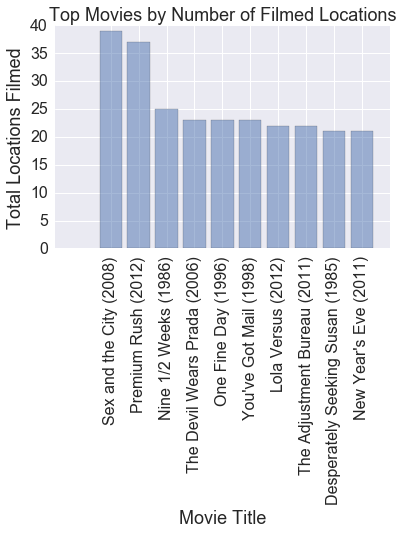

In [29]:
x_axis = movies_df[['title','total_loc']].sort('total_loc', ascending=False)[:10]['title']
y_axis = movies_df[['title','total_loc']].sort('total_loc',\
        ascending=False)[:10]['total_loc']
pos = np.arange(len(x_axis))

plt.bar(pos, y_axis, align='center', alpha=0.5)
plt.xticks(pos, x_axis, rotation = 'vertical', fontsize=16)
plt.yticks(fontsize=16)
plt.title('Top Movies by Number of Filmed Locations',\
         fontsize = 18)
plt.xlabel('Movie Title', fontsize = 18)
plt.ylabel('Total Locations Filmed', fontsize = 18)

## Locations over time

In [28]:
loc_count[['location']].plot()
plt.title('Total Locations Filmed in NYC by Year', fontsize = 18)
plt.xlabel('Year', fontsize=16)
plt.xticks(fontsize=14, rotation=45)
plt.ylabel('Total Locations Filmed', fontsize=16)

<img src='tableau.png'>

# Points for Future Analysis
# - complete batch geocoding
# - plot all film locations on a map
# - arrange by year, genre
# - what were the most popular locations

